In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from xml.etree import ElementTree as ET
from shared_utils.general import get_project_root
from itertools import product

import matplotlib.pyplot as plt

In [3]:
muscle_range_path = os.path.join(get_project_root(), "generated_xml", "elbow_muscles_ranges", "muscle_ranges_sample.xml")
assert os.path.isfile(muscle_range_path)

In [4]:
root = ET.parse(muscle_range_path)

#### Study of the evolution of the muscle ranges as a function of scales

In [5]:
ua_scales = [.9, .95, 1, 1.05, 1.1]
la_scales = ua_scales

studied_muscle = "bic_l"

muscle_ranges = np.zeros((len(ua_scales), len(la_scales), 2))

for ua_idx, la_idx in product(range(len(ua_scales)), range(len(la_scales))):
    # find right sample in root
    scale_sample = root.findall(f"./model_sample[@ua_s=\"{ua_scales[ua_idx]}\"][@la_s=\"{la_scales[la_idx]}\"]")
    assert len(scale_sample) == 1
    scale_sample = scale_sample[0]

    # find muscle in sample
    muscle = scale_sample.findall(f"./muscle[@name=\"{studied_muscle}\"]")
    assert len(muscle) == 1
    muscle = muscle[0]

    # extract upper and lower range
    muscle_ranges[ua_idx, la_idx, 0] = float(muscle.attrib["lower_bound"])
    muscle_ranges[ua_idx, la_idx, 1] = float(muscle.attrib["upper_bound"])

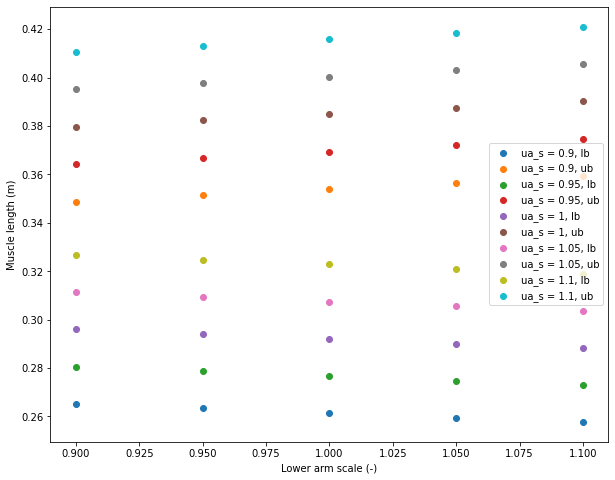

In [6]:
plt.figure(figsize=(10, 8))

for ua_idx in range(len(ua_scales)):
    plt.scatter(la_scales, muscle_ranges[ua_idx, :, 0], label=f"ua_s = {ua_scales[ua_idx]}, lb")
    plt.scatter(la_scales, muscle_ranges[ua_idx, :, 1], label=f"ua_s = {ua_scales[ua_idx]}, ub")

plt.legend()
plt.ylabel("Muscle length (m)")
plt.xlabel("Lower arm scale (-)")

plt.show()

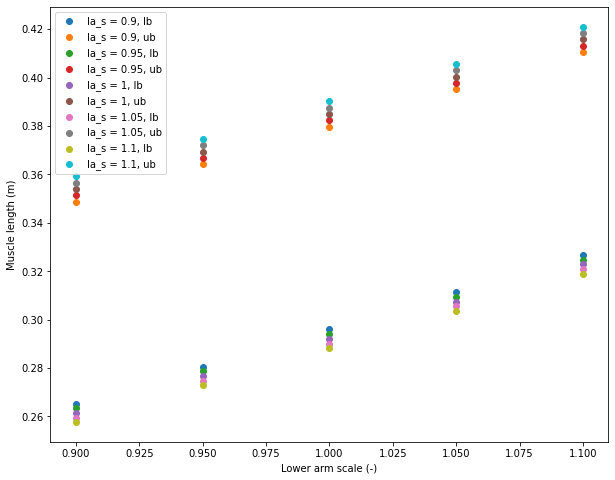

In [7]:
plt.figure(figsize=(10, 8))

for la_idx in range(len(la_scales)):
    plt.scatter(ua_scales, muscle_ranges[:, la_idx, 0], label=f"la_s = {la_scales[la_idx]}, lb")
    plt.scatter(ua_scales, muscle_ranges[:, la_idx, 1], label=f"la_s = {la_scales[la_idx]}, ub")

plt.legend()
plt.ylabel("Muscle length (m)")
plt.xlabel("Lower arm scale (-)")

plt.show()

It seems that it can be approximated by a linear regression

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
cartesian_prod_idx = [[ua_idx, la_idx] for ua_idx, la_idx in product(range(len(ua_scales)), range(len(la_scales)))]
cartesian_prod_scales = np.array([[ua_scales[i], la_scales[j]] for i,j in cartesian_prod_idx])
lb_targets = np.array([ muscle_ranges[i,j,0] for i,j in cartesian_prod_idx])
ub_targets = np.array([ muscle_ranges[i,j,1] for i,j in cartesian_prod_idx])

First let's do it for the lower bound

In [10]:
lb_reg = LinearRegression().fit(X=cartesian_prod_scales, y=lb_targets)
lb_reg.score(X=cartesian_prod_scales, y=lb_targets)

0.9999955740574189

Now the upper bound

In [11]:
ub_reg = LinearRegression().fit(X=cartesian_prod_scales, y=ub_targets)
ub_reg.score(X=cartesian_prod_scales, y=ub_targets)

0.9999995502033211

Very good fit, let's visualise things now.

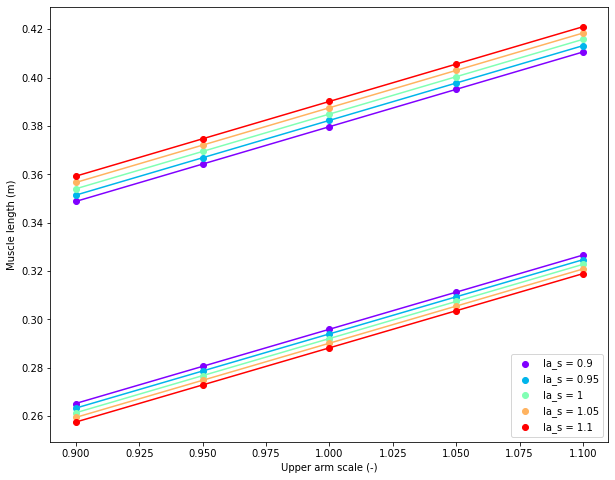

In [12]:
N = 20

la_s_linspace = np.linspace(.9, 1.1, N)
ua_s_linspace = la_s_linspace
ua_s_linspace = ua_s_linspace.reshape(-1,1)

# we use a color iterator
color_iter = iter(plt.cm.rainbow(np.linspace(0, 1, len(la_scales))))
plt.figure(figsize=(10, 8))

for la_idx in range(len(la_scales)):

    la_scale = la_scales[la_idx]
    la_scale_rep = np.ones((len(ua_s_linspace), 1)) * la_scale

    X = np.concatenate((ua_s_linspace, la_scale_rep), axis = 1)
    ub_y = ub_reg.predict(X)
    lb_y = lb_reg.predict(X)

    c = next(color_iter)
    plt.plot(ua_s_linspace.reshape(-1), ub_y, color=c)
    plt.scatter(ua_scales, muscle_ranges[:, la_idx, 1], color=c, label=f"la_s = {la_scales[la_idx]}")

    plt.plot(ua_s_linspace.reshape(-1), lb_y, color=c)
    plt.scatter(ua_scales, muscle_ranges[:, la_idx, 0], color=c)
    
plt.legend(loc="lower right")
plt.ylabel("Muscle length (m)")
plt.xlabel("Upper arm scale (-)")

plt.show()

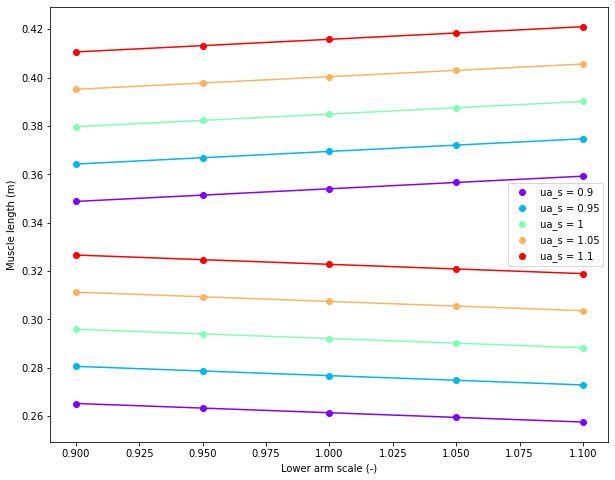

In [13]:
N = 20

la_s_linspace = np.linspace(.9, 1.1, N).reshape(-1,1)

# we use a color iterator
color_iter = iter(plt.cm.rainbow(np.linspace(0, 1, len(la_scales))))
plt.figure(figsize=(10, 8))

for ua_idx in range(len(ua_scales)):

    ua_scale = ua_scales[ua_idx]
    ua_scale_rep = np.ones((len(la_s_linspace), 1)) * ua_scale

    X = np.concatenate((ua_scale_rep, la_s_linspace), axis = 1)
    ub_y = ub_reg.predict(X)
    lb_y = lb_reg.predict(X)

    c = next(color_iter)
    plt.plot(la_s_linspace.reshape(-1), ub_y, color=c)
    plt.scatter(la_scales, muscle_ranges[ua_idx, :, 1], color=c, label=f"ua_s = {ua_scales[ua_idx]}")

    plt.plot(la_s_linspace.reshape(-1), lb_y, color=c)
    plt.scatter(la_scales, muscle_ranges[ua_idx, :, 0], color=c)

plt.legend(loc="center right") 
plt.ylabel("Muscle length (m)")
plt.xlabel("Lower arm scale (-)")

plt.show()

### Check that linear regression works for roughly all models

In [14]:
def get_muscle_ranges(muscle_name:str, xml_file_path: str, ua_scales: list, la_scales: list) -> np.ndarray:
    assert os.path.isfile(xml_file_path)

    root = ET.parse(xml_file_path)
    muscle_ranges = np.zeros((len(ua_scales), len(la_scales), 2))

    for ua_idx, la_idx in product(range(len(ua_scales)), range(len(la_scales))):
        # find right sample in root
        scale_sample = root.findall(f"./model_sample[@ua_s=\"{ua_scales[ua_idx]}\"][@la_s=\"{la_scales[la_idx]}\"]")
        assert len(scale_sample) == 1
        scale_sample = scale_sample[0]

        # find muscle in sample
        muscle = scale_sample.findall(f"./muscle[@name=\"{muscle_name}\"]")
        assert len(muscle) == 1
        muscle = muscle[0]

        # extract upper and lower range
        muscle_ranges[ua_idx, la_idx, 0] = float(muscle.attrib["lower_bound"])
        muscle_ranges[ua_idx, la_idx, 1] = float(muscle.attrib["upper_bound"])

    return muscle_ranges


In [15]:
def get_X_ulb_y(muscle_ranges: np.ndarray, ua_scales: list, la_scales: list):
    cartesian_prod_idx = [[ua_idx, la_idx] for ua_idx, la_idx in product(range(len(ua_scales)), range(len(la_scales)))]
    cartesian_prod_scales = np.array([[ua_scales[i], la_scales[j]] for i,j in cartesian_prod_idx])
    lb_targets = np.array([ muscle_ranges[i,j,0] for i,j in cartesian_prod_idx])
    ub_targets = np.array([ muscle_ranges[i,j,1] for i,j in cartesian_prod_idx])

    return cartesian_prod_scales, lb_targets, ub_targets

In [16]:
X, lb_y, ub_y = get_X_ulb_y(muscle_ranges, ua_scales, la_scales)

In [17]:
def get_reg_score(X: np.ndarray, y: np.ndarray):
    reg = LinearRegression().fit(X=X, y=y)
    return reg.score(X, y)

In [18]:
muscle_list = ["tric_long_avg", "tric_med_avg", "tric_lat_avg",
                   "anconeus_avg", "bic_b_avg", "bic_l", "brachialis_avg", "brachiorad_avg"]

la_scales = ua_scales = [.9, .95, 1, 1.05, 1.1]

for muscle in muscle_list:
    muscle_ranges = get_muscle_ranges(muscle, muscle_range_path, ua_scales, la_scales)
    X, lb_y, ub_y = get_X_ulb_y(muscle_ranges, ua_scales, la_scales)

    lb_reg = LinearRegression().fit(X=X, y=lb_y)
    s1 = lb_reg.score(X, lb_y)

    ub_reg = LinearRegression().fit(X=X, y=ub_y)
    s2 = ub_reg.score(X, ub_y)

    print(f"{muscle: <14}: ub R2: {s2: <18} ; lb R2: {s1}")


tric_long_avg : ub R2: 0.9999999497865476 ; lb R2: 0.9999998841051229
tric_med_avg  : ub R2: 0.9999947940085454 ; lb R2: 0.999883899792029
tric_lat_avg  : ub R2: 0.999999655487567  ; lb R2: 0.999996308511813
anconeus_avg  : ub R2: 0.9999704081016352 ; lb R2: 0.9991923854106265
bic_b_avg     : ub R2: 0.9999997535288419 ; lb R2: 0.9999931197918668
bic_l         : ub R2: 0.9999995502033211 ; lb R2: 0.9999955740574189
brachialis_avg: ub R2: 0.9999977337182461 ; lb R2: 0.9999147286947362
brachiorad_avg: ub R2: 0.9999999867435341 ; lb R2: 0.9999695441254008


R2 coefficient are high enough: it is worth using the linear model in the limitation of [.9, 1.1]

In [19]:
muscle_list = ["tric_long_avg", "tric_med_avg", "tric_lat_avg",
                   "anconeus_avg", "bic_b_avg", "bic_l", "brachialis_avg", "brachiorad_avg"]

la_scales = ua_scales = [.9, .95, 1, 1.05, 1.1]

for muscle in muscle_list:
    muscle_ranges = get_muscle_ranges(muscle, muscle_range_path, ua_scales, la_scales)
    X, lb_y, ub_y = get_X_ulb_y(muscle_ranges, ua_scales, la_scales)

    lb_reg = LinearRegression().fit(X=X, y=lb_y)
    ub_reg = LinearRegression().fit(X=X, y=ub_y)

    # print the desired muscle range element
    ub_string=f"scale_ua*{ub_reg.coef_[0]}+scale_la*{ub_reg.coef_[1]}+({ub_reg.intercept_})"
    lb_string = f"scale_ua*{lb_reg.coef_[0]}+scale_la*{lb_reg.coef_[1]}+({lb_reg.intercept_})"
    lengthrange_string = f"${{{lb_string}}} ${{{ub_string}}}"
    print(f'<muscle name="{muscle}" tendon="{muscle}" force="${{{muscle+"_F"}}}" lengthrange="{lengthrange_string}"/>\n')


<muscle name="tric_long_avg" tendon="tric_long_avg" force="${tric_long_avg_F}" lengthrange="${scale_ua*0.2898858674353134+scale_la*-0.016197458114566743+(0.014813932587159961)} ${scale_ua*0.28983932485885494+scale_la*0.03052474343079788+(0.015958814565568247)}"/>

<muscle name="tric_med_avg" tendon="tric_med_avg" force="${tric_med_avg_F}" lengthrange="${scale_ua*0.11025358354023396+scale_la*-0.007723164995852885+(9.536098914422753e-05)} ${scale_ua*0.11471482122301414+scale_la*0.03231033560947752+(2.263260479895557e-05)}"/>

<muscle name="tric_lat_avg" tendon="tric_lat_avg" force="${tric_lat_avg_F}" lengthrange="${scale_ua*0.2174593522823665+scale_la*-0.019397482467486838+(3.254399653560003e-05)} ${scale_ua*0.2188742092502271+scale_la*0.03132642780917889+(1.1464761564716763e-05)}"/>

<muscle name="anconeus_avg" tendon="anconeus_avg" force="${anconeus_avg_F}" lengthrange="${scale_ua*-0.012068284830180099+scale_la*0.030644474331774425+(7.449213124305354e-05)} ${scale_ua*0.0154294921236901

The above values are copy pasted in the xacro model